In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import random
import string
import re

## Preprocess Training Dataset

### Organizing Dataset into Pandas Data Frame

In [2]:
# open all JSON file and put into array
def open_json(filepath):
    meme = []
    meme_link = []
    meme_text = []

    with open('dataset/memes/' + filepath) as f:
        data = json.load(f)
        meme.extend([ filepath.split('.')[0] ] * len(data))
        meme_link.extend([ data[idx]['url'] for idx in range(len(data)) ])
        meme_text.extend([ data[idx]['boxes'] for idx in range(len(data)) ])
        
    return meme, meme_link, meme_text

In [3]:
# place all data into pandas dataframe
df = pd.DataFrame()

meme = []
meme_link = []
meme_text = []

for filepath in os.listdir('dataset/memes'):
    a, b, c = open_json(filepath)
    meme.extend(a)
    meme_link.extend(b)
    meme_text.extend(c)
     
df['meme'] = meme
df['meme_link'] = meme_link
df['meme_text'] = meme_text
df['len_boxes'] = df['meme_text'].apply(lambda x: len(x))

In [4]:
df.head()

,meme,meme_link,meme_text,len_boxes
0,10-Guy,https://i.imgflip.com/3vmgm2.jpg,"[DAY 20 OF QUARANTINE, ""WHAT'S A TREE?""]",2
1,10-Guy,https://i.imgflip.com/3w3rkx.jpg,"[DRANK 19 CORONAS, WONT RISK SPREADING CORONA ...",2
2,10-Guy,https://i.imgflip.com/3ve9ld.jpg,[HOW ARE WE SUPPOSED TO SNEEZE AND COUGH INTO ...,1
3,10-Guy,https://i.imgflip.com/3tastf.jpg,"[THERE SHOULD BE WATERMELON, FIREMELON, EARTHM...",2
4,10-Guy,https://i.imgflip.com/3c35zd.jpg,"[If you rotate the word ""pod"", it still spells...",2


### Visualizing Distribution of Data

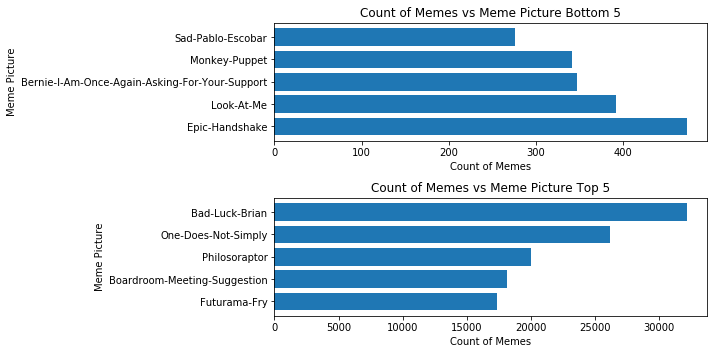

In [5]:
# display plots of distribution of data
fig, ax = plt.subplots(2,1, figsize=(10,5))
df_counts = df['meme'].value_counts().reset_index()
low_counts = df_counts.sort_values('meme', inplace = False, ascending = True)[:5]
high_counts = df_counts.sort_values('meme', inplace = False, ascending = False)[:5]

ax[0].barh(low_counts['index'], low_counts['meme'])
ax[0].invert_yaxis()
ax[0].set_xlabel('Count of Memes')
ax[0].set_ylabel('Meme Picture')
ax[0].set_title('Count of Memes vs Meme Picture Bottom 5')
ax[1].barh(high_counts['index'], high_counts['meme'])
ax[1].invert_yaxis()
ax[1].set_xlabel('Count of Memes')
ax[1].set_ylabel('Meme Picture')
ax[1].set_title('Count of Memes vs Meme Picture Top 5')

fig.tight_layout(pad = 1)

### Filtering Data: Must equal ideal boxes

In [6]:
# number of lines expected per meme
num_lines = {
    '10-Guy': 2,
    'Aaaaand-Its-Gone': 2,
    'Aint-Nobody-Got-Time-For-That': 2,
    'Am-I-The-Only-One-Around-Here': 2,
    'American-Chopper-Argument': 5, # maybe4
    'Ancient-Aliens': 2,
    'And-everybody-loses-their-minds': 2,
    'Archer': 2,
    'Awkward-Moment-Sealion': 2, 
    'Back-In-My-Day': 2, 
    'Bad-Luck-Brian': 2,
    'Bad-Pun-Dog': 2, #maybe 3 
    'Batman-Slapping-Robin': 2, 
    'Be-Like-Bill': 4,
    'Bernie-I-Am-Once-Again-Asking-For-Your-Support': 2, 
    'Black-Girl-Wat': 2,
    'Blank-Nut-Button': 2, 
    'Boardroom-Meeting-Suggestion': 4,
    'Brace-Yourselves-X-is-Coming': 2, 
    'But-Thats-None-Of-My-Business': 2,
    'Captain-Picard-Facepalm': 2,
    'Change-My-Mind': 1, 
    'Confession-Bear': 2,
    'Conspiracy-Keanu': 2,
    'Creepy-Condescending-Wonka': 2, 
    'Disaster-Girl': 2, #maybe1
    'Doge': 4, 
    'Dont-You-Squidward': 2, 
    'Dr-Evil-Laser': 2,
    'Drake-Hotline-Bling': 2, 
    'Epic-Handshake': 3, 
    'Evil-Kermit': 2,
    'Evil-Toddler': 2, 
    'Expanding-Brain': 4,
    'Face-You-Make-Robert-Downey-Jr': 2, 
    'Finding-Neverland': 3,
    'First-World-Problems': 2, 
    'Futurama-Fry': 2,
    'Grandma-Finds-The-Internet': 2, 
    'Grumpy-Cat': 2,
    'Hard-To-Swallow-Pills': 2, 
    'Hide-the-Pain-Harold': 2,
    'I-Should-Buy-A-Boat-Cat': 2, 
    'Ill-Just-Wait-Here': 2,
    'Imagination-Spongebob': 2, 
    'Inhaling-Seagull': 2, 
    'Is-This-A-Pigeon': 3,
    'Jack-Sparrow-Being-Chased': 3, 
    'Laughing-Men-In-Suits': 2,
    'Left-Exit-12-Off-Ramp': 3, 
    'Leonardo-Dicaprio-Cheers': 2, 
    'Look-At-Me': 2,
    'Marked-Safe-From': 1, 
    'Matrix-Morpheus': 2, 
    'Maury-Lie-Detector': 2,
    'Mocking-Spongebob': 2, 
    'Monkey-Puppet': 1, 
    'Mugatu-So-Hot-Right-Now': 2,
    'One-Does-Not-Simply': 2, 
    'Oprah-You-Get-A': 2, 
    'Philosoraptor': 2,
    'Picard-Wtf': 2, 
    'Put-It-Somewhere-Else-Patrick': 2,
    'Roll-Safe-Think-About-It': 2, 
    'Running-Away-Balloon': 5,
    'Sad-Pablo-Escobar': 3, 
    'Say-That-Again-I-Dare-You': 2, 
    'Scumbag-Steve': 2,
    'See-Nobody-Cares': 2, 
    'Skeptical-Baby': 2, 
    'Sparta-Leonidas': 2,
    'Spongebob-Ight-Imma-Head-Out': 1, 
    'Star-Wars-Yoda': 2,
    'Steve-Harvey': 2,
    'Success-Kid': 2, 
    'Surprised-Pikachu': 2,
    'That-Would-Be-Great': 2,
    'The-Most-Interesting-Man-In-The-World': 2,
    'The-Rock-Driving': 2,
    'The-Scroll-Of-Truth': 1,
    'Third-World-Skeptical-Kid': 2,
    'Third-World-Success-Kid': 2,
    'This-Is-Where-Id-Put-My-Trophy-If-I-Had-One': 2, 
    'Too-Damn-High': 2,
    'Trump-Bill-Signing': 2, 
    'Tuxedo-Winnie-The-Pooh': 2,
    'Two-Buttons': 2,
    'UNO-Draw-25-Cards': 2,
    'Uncle-Sam': 2,
    'Unsettled-Tom': 2,
    'Waiting-Skeleton': 2,
    'Who-Killed-Hannibal': 3,
    'Who-Would-Win': 2,
    'Woman-Yelling-At-Cat': 2,
    'X-All-The-Y': 2,
    'X-X-Everywhere': 2,
    'Y-U-No': 2,
    'Yall-Got-Any-More-Of-That': 2,
    'Yo-Dawg-Heard-You': 2
}

In [7]:
# organize into dataframe
ideal_len = pd.DataFrame.from_dict(num_lines, orient='index').reset_index()
ideal_len.columns = ['meme', 'ideal_boxes']
ideal_len.head()

,meme,ideal_boxes
0,10-Guy,2
1,Aaaaand-Its-Gone,2
2,Aint-Nobody-Got-Time-For-That,2
3,Am-I-The-Only-One-Around-Here,2
4,American-Chopper-Argument,5


In [8]:
# memes with > 2 boxes per image
ideal_len[ideal_len['ideal_boxes'] > 2]

,meme,ideal_boxes
4,American-Chopper-Argument,5
13,Be-Like-Bill,4
17,Boardroom-Meeting-Suggestion,4
26,Doge,4
30,Epic-Handshake,3
33,Expanding-Brain,4
35,Finding-Neverland,3
46,Is-This-A-Pigeon,3
47,Jack-Sparrow-Being-Chased,3
49,Left-Exit-12-Off-Ramp,3


In [9]:
# join both dataframes
df = pd.merge(df, ideal_len, left_on = 'meme', right_on = 'meme')

# filter the memes with expected number of text
df = df[df['len_boxes'] == df['ideal_boxes']].reset_index(drop = True)

In [10]:
df.head()

,meme,meme_link,meme_text,len_boxes,ideal_boxes
0,10-Guy,https://i.imgflip.com/3vmgm2.jpg,"[DAY 20 OF QUARANTINE, ""WHAT'S A TREE?""]",2,2
1,10-Guy,https://i.imgflip.com/3w3rkx.jpg,"[DRANK 19 CORONAS, WONT RISK SPREADING CORONA ...",2,2
2,10-Guy,https://i.imgflip.com/3tastf.jpg,"[THERE SHOULD BE WATERMELON, FIREMELON, EARTHM...",2,2
3,10-Guy,https://i.imgflip.com/3c35zd.jpg,"[If you rotate the word ""pod"", it still spells...",2,2
4,10-Guy,https://i.imgflip.com/3g89a4.jpg,"[I TRIED TO BRAINSTORM ONCE, BUT I GOT LOST IN...",2,2


### Filtering Data: Remove Unprintables Characters

In [11]:
charlist = list(string.printable)

# Remove non Printable characters (ex: Emojis, non-english characters)
def preprocess_text(x):
    x = [elem.lower() for elem in x]
    for elem in x:
        for char in elem:
            if char in charlist:
                continue
            else:
                return 'REMOVE'
    
    # replace uncommon characters (ex: \n and \t) to spaces
    for idx, elem in enumerate(x):
        temp = elem
        temp = temp.replace("\n", " ")
        temp = temp.replace("\t", " ")
        # remove multiple spaces
        temp = re.sub(r'\s{2,}', ' ', temp)
        x[idx] = temp
    return x

# apply text cleaning
df['clean_text'] = df['meme_text'].apply(lambda x: preprocess_text(x))
df = df[df['clean_text'] != 'REMOVE']

### Filtering Data: Remove Long Characters

In [12]:
# get all text in array format
all_text = []
for elem in df['clean_text']:
    all_text.extend(elem)

# get all unique characters
all_text = ' '.join(all_text)
all_chars = set(all_text)

In [13]:
# create dictionary mapping of characters
char2idx = {"<pad>": 0}

for idx, elem in enumerate(all_chars):
    char2idx[elem] = idx + 1

# add special tokens
char2idx["<start>"] = len(char2idx)
char2idx["<end>"] = len(char2idx)
char2idx["<sep>"] = len(char2idx)

idx2char = {value:key for key, value in char2idx.items()}

# save char mapping
a = json.dumps(char2idx)
f = open("dataset_final/char2idx.json","w")
f.write(a)
f.close()

In [14]:
# encode the strings
def encode_characters(x):
    curr_meme = x['meme']
    curr_text = x['clean_text']    
    
    char_enc = [char2idx['<start>']]
    for idxlen, elem in enumerate(curr_text):
        for char in elem:
            char_enc.append(char2idx[char])
        if idxlen != len(curr_text) - 1:
            char_enc.append(char2idx['<sep>'])
    char_enc.append(char2idx['<end>'])
    
    return char_enc

# apply character encoding
df['clean_text_enc']  = df.apply(lambda x: encode_characters(x), axis = 1)
df['len_clean_text_enc'] = df['clean_text_enc'].apply(lambda x: len(x))

Percentage above len 200 chars: 0.8002610511108929 %


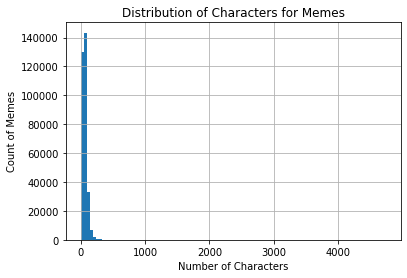

In [15]:
# here we see that a majority of the memes had less than 200 characters
df['len_clean_text_enc'].hist(bins=100)
plt.xlabel("Number of Characters")
plt.ylabel("Count of Memes")
plt.title("Distribution of Characters for Memes");

num_gt_200 = df[df['len_clean_text_enc'] > 200].shape[0]
overall = df.shape[0]

print("Percentage above len 200 chars:", num_gt_200 * 100 / overall, "%")

# filter anything above 200 chars
df = df[df['len_clean_text_enc'] <= 200].reset_index(drop = True)

Current Data Size:  313121


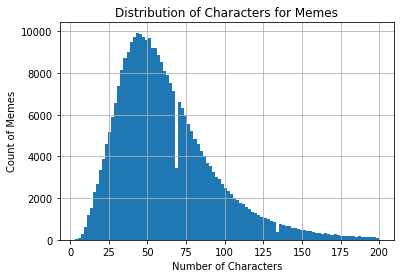

In [16]:
# distribution after limiting to 200 characters
df['len_clean_text_enc'].hist(bins=100)
plt.xlabel("Number of Characters")
plt.ylabel("Count of Memes")
plt.title("Distribution of Characters for Memes");

print("Current Data Size: ", df.shape[0])

### Subsample Dataset

In [17]:
grouped = df.groupby(['meme'])['meme_text'].agg(['count']).reset_index()
grouped.head()

,meme,count
0,10-Guy,4651
1,Aaaaand-Its-Gone,1294
2,Aint-Nobody-Got-Time-For-That,670
3,Am-I-The-Only-One-Around-Here,3777
4,American-Chopper-Argument,748


In [18]:
# set random seed
random.seed(224)

# store kept indexes
keep_idx = []

# for each meme sample 1000 memes randomly (if available), if less than 1000 data available use all data
for elem in grouped['meme']:
    temp = list(df[df['meme'] == elem].index)
    if len(temp) < 1000:
        keep_idx.extend(temp)
    else:
        temp = random.sample(temp, 1000) 
        keep_idx.extend(temp)
    
keep_idx = list(keep_idx)

# filter by keep index only
df = df.loc[keep_idx,:].reset_index(drop = True)

In [19]:
df.head()

,meme,meme_link,meme_text,len_boxes,ideal_boxes,clean_text,clean_text_enc,len_clean_text_enc
0,10-Guy,https://i.imgflip.com/1pwc7o.jpg,"[MY GIRLFRIEND TEXTED ME YESTERDAY SAYING ""I W...",2,2,"[my girlfriend texted me yesterday saying ""i w...","[69, 33, 68, 45, 44, 42, 60, 54, 35, 60, 42, 3...",145
1,10-Guy,https://i.imgflip.com/1tzq64.jpg,[I JUST OPENED AN ALL-NIGHT CAR SMOG AND OIL C...,2,2,[i just opened an all-night car smog and oil c...,"[69, 42, 45, 53, 47, 48, 56, 45, 49, 14, 34, 1...",87
2,10-Guy,https://i.imgflip.com/1amrco.jpg,"[WHILE VISITING IRAQ I HEARD SOMEONE YELL, ""ST...",2,2,"[while visiting iraq i heard someone yell, ""st...","[69, 43, 36, 42, 54, 34, 45, 57, 42, 48, 42, 5...",144
3,10-Guy,https://i.imgflip.com/1zo2dj.jpg,"[APPLE SHOULD MAKE A BIG SCREEN TV, AND CALL I...",2,2,"[apple should make a big screen tv, and call i...","[69, 51, 14, 14, 54, 34, 45, 48, 36, 49, 47, 5...",59
4,10-Guy,https://i.imgflip.com/1s4vrx.jpg,"[SAVAGE_KING013, LITERALLY YOU RIGHT NOW]",2,2,"[savage_king013, literally you right now]","[69, 48, 51, 57, 51, 44, 34, 7, 55, 42, 19, 44...",40


In [21]:
final = df.loc[:, ['meme', 'meme_link']]
final.head()

,meme,meme_link
0,10-Guy,https://i.imgflip.com/1pwc7o.jpg
1,10-Guy,https://i.imgflip.com/1tzq64.jpg
2,10-Guy,https://i.imgflip.com/1amrco.jpg
3,10-Guy,https://i.imgflip.com/1zo2dj.jpg
4,10-Guy,https://i.imgflip.com/1s4vrx.jpg


In [22]:
# save to local
final.to_csv('app/backend/sample.csv', index = False)